# Data Science 2 Seminar
## Business/project evaluation stage

### Premise
Vacations/holidays have a visible effect on CoViD-19 infection rates in the tri-state area.

If that can be shown, I will try to form a prediction model for future holidays or give an idea what is possible in this model an what's not.
We know that effects changing the infection rate matter for the following 5-12 days. So a 14 day window will be used applied for the factors.

### Python
Versions of the central libraries
* Python 3.9.4
* Pandas 1.2.4
* sklearn 0.24.2
* skforecast 0.4.1

## Init

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

from helpers import *
# Some of the hyperparameters/statics can be found in init.py
import init as util

from dataprep import  *

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# make the graphs actually viewable
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

class Settings(object):
    incident_window_size = 7 # days
    change_rate_window_size = 7 # days
    off_day_relevance_window = 14 # days
    # timeframe used from the base data. Had some instances where data at the start of end got sketchy, so a clear cut-off produced better results
    timeframe_start = dt.strptime('2020-03-15',"%Y-%m-%d")
    timeframe_end = dt.strptime('2021-12-31',"%Y-%m-%d")
    training_columns = ['NDRC_SW_Yesterday','OffDayFactor', 'OffDay'] # columns used in training the algorithms

    # Data sources
    generate_data = False       # read data from original source
    save_generated_data = True  # write the data to the datapreparation cache files
    load_pregenerated_data = True # load the data from the pregenerated cache files
    
    base_dir = "./"
    data_dir = base_dir + "datasets/"
    source_dir = data_dir + 'orig/'

    # all paths relative to this document
    original_be_data = source_dir + 'COVID19BE_CASES_AGESEX.csv'
    original_nl_data = source_dir + 'COVID-19_aantallen_gemeente_cumulatief.csv'
    original_de_data = source_dir + 'RKI_COVID19_Nordrhein-Westfalen.csv'

    # cache files
    emr_infection_data = data_dir + "EMR_prepared.csv"
    de_reference_data = data_dir + "de_ref_cal.csv"
    nl_reference_data = data_dir + "nl_ref_cal.csv"
    be_reference_data = data_dir + "be_ref_cal.csv"

settings = Settings()

## Data preparation stage

The area of relevance is the EMR (Euregio Maas-Rhine region) as defined by the EU.
* The CoViD-19 data corresponding to that area is collected from 
  * https://data.rivm.nl/covid-19/
  * https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.csv
  * https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/a99afefd4258435f8af660b6cbed9bf7_0/explore

* The original formats are all UTF-8 encoded CSV, whereas BE and DE data is comma separated and NL is semicolon separated
* German and belgian data contains daily cases
* Dutch data contains total cases and needs to be converted

* Original data then consists of
  * Date
  * Province reference
  * Daily total cases
* Additional derived fields are added
  * Daily cases per 100k inhabitants
  * A sliding window rate for N-Days
  * A change rate for the N-Day-Rate
  * A sliding window variant of the change rate
* The compiled dataset is saved/cached as CSV

* The holiday and school-holidays are compiled in separate datasets
* They contain the following features per day
  * Date
  * Province reference
  * Holiday
  * Vacation day
  * OffDay
  * OffDayFactor (a factor calculated as the sum of OffDays over a certain period)

In [2]:
if settings.generate_data:
    emr_df = prepareData(settings)
    be_ref_df, nl_ref_df, de_ref_df = prepareRefCals(settings)

### Importing previously prepared data

Reloading generated data from cache to reduce run-times

In [3]:
if settings.load_pregenerated_data:
    emr_df = pd.read_csv(settings.emr_infection_data)
    emr_df = addDateTypeColumn(emr_df,'Date')

    be_ref_df, nl_ref_df, de_ref_df = loadRefData(settings)

Combining datasets with their respective OffDays and grouping by off days

In [4]:
de_off_dfs = {}
nl_off_dfs = {}
be_off_dfs = {}

for i in [10,20,30,40]:
    de_off_dfs[i] = prepareDf(emr_df, i, de_ref_df)

for i in [10,20,30,40]:
    nl_off_dfs[i] = prepareDf(emr_df, i, nl_ref_df)

for i in [10,20,30,40]:
    be_off_dfs[i] = prepareDf(emr_df, i, be_ref_df)


## Verify interval completeness
Since certain data remained riddled with missing days, we verify that the timestretches we use are complete.
Missing days are mostly the result of 0 incidence days or delay in registering the cases

In [5]:
for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
    for k, df in df_dict.items():
        print('Off days: {od} provinceId: {pid} complete: {comp}'.format(od=name, pid =k, comp=(df.index == pd.date_range(start=df.index.min(),
                                    end=df.index.max(),
                                    freq=df.index.freq)).all()))

Off days: be provinceId: 10 complete: True
Off days: be provinceId: 20 complete: True
Off days: be provinceId: 30 complete: True
Off days: be provinceId: 40 complete: True
Off days: nl provinceId: 10 complete: True
Off days: nl provinceId: 20 complete: True
Off days: nl provinceId: 30 complete: True
Off days: nl provinceId: 40 complete: True
Off days: de provinceId: 10 complete: True
Off days: de provinceId: 20 complete: True
Off days: de provinceId: 30 complete: True
Off days: de provinceId: 40 complete: True


# Ridge Regression

RR yields similar results concerning errors as Gradient Boosting does

In [6]:
from sklearn.datasets import make_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

pt_gbtr_df = de_off_dfs[30].copy()
X, y = pt_gbtr_df.loc[:, settings.training_columns], pt_gbtr_df.NDRC_Sliding_Window

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

gbtReg = KernelRidge()
gbtReg.fit(X_train, y_train)
gbtReg.score(X_test, y_test) # R2

0.6849798878983979

# SVM
During initial tryouts SVM yielded significantly worse results compared to both RR and Gradient Boosting.
After running a grid search the results aren't as far off anymore, but still slightly worse compared to Gradient Boosting.

In [7]:
gbtr_df = de_off_dfs[30].copy()
X, y = gbtr_df.loc[:, settings.training_columns], gbtr_df.NDRC_Sliding_Window

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

regr = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # R2

-0.2514353561051441

## Grid Search

In [8]:
def doGridSearchForSVM():
    param_grid = {
        'kernel': ['rbf', 'linear', 'poly'],
        'C': [1, 10, 100],
        'gamma': [1e-3, 1e-4],
        'epsilon': [0.2],
    }

    svr = SVR()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                            cv = cv, n_jobs = -1, verbose = 0, scoring='neg_mean_absolute_error')
    results = pd.DataFrame(columns={'region','offdays','score'})

    for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
        for k, df in df_dict.items():
            X = df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']]
            y = df.NDRC_Sliding_Window
            grid_search.fit(X, y)
            res = grid_search.best_params_.copy()
            res['offdays'] = name
            res['region'] = util.class_labels[k]
            res['score'] = grid_search.best_score_
            results = results.append(res, ignore_index=True)
    return results

In [9]:
# doGridSearchForSVM()

# Gradient Boosting Regressor

In [10]:
pt_gbtr_df = de_off_dfs[30].copy()
X, y = pt_gbtr_df.loc[:,settings.training_columns], pt_gbtr_df.NDRC_Sliding_Window

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# From Gridsearch
params = {'learning_rate': 0.075,
 'max_depth': 3,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 80,
 'subsample': 0.85
 }

gbtReg = GradientBoostingRegressor( random_state=0, **params)

gbtReg.fit(X_train, y_train)
gbtReg.score(X_test, y_test) # R2

0.6888012453547856

## Grid search
I performed a grid search to find the best overall parameters and to have a comparison/measure of the stability/impacts of the off days on their respective countries, the neighbouring countries and the EMR as a whole.

The original grid params are commented out to have it run in reasonable time.

In [11]:
def doGridSearchForGradientBoostingRegressor():
    # param_grid = {
    #     'max_depth': [2, 3, 5, 10],
    #     'subsample': [0.05, 0.1, 0.2, 0.5, 0.8, 0.85, 0.9],
    #     'n_estimators': [10, 50, 80, 90, 100, 200, 500],
    #     'learning_rate': [0.01, 0.02, 0.05,0.075, 0.1, 0.5],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [2, 5, 10]
    # }

    param_grid = {
        'max_depth': [3],
        'subsample': [0.85],
        'n_estimators': [80, 90, 100],
        'learning_rate': [0.075],
        'min_samples_split':[2],
        'min_samples_leaf':[10]
    }

    gbr = GradientBoostingRegressor(random_state=1)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, 
                            cv = cv, n_jobs = -1, verbose = 0, scoring='neg_mean_absolute_error')
    results = pd.DataFrame(columns={'region','offdays','score'})

    for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
        for k, df in df_dict.items():
            X = df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']]
            y = df.NDRC_Sliding_Window
            grid_search.fit(X, y)
            res = grid_search.best_params_.copy()
            res['offdays'] = name
            res['region'] = util.class_labels[k]
            res['score'] = grid_search.best_score_
            results = results.append(res, ignore_index=True)
    return results

The resulting scores show that on very similar parameters the predictions of incident changes for off-days corresponding to their own country are reasonably stable. Across borders and spanning the whole EMR are roughly equally well. 
The scores as such seem to be in a range where they give predictions in the right ball park but aren't suitable/stable enough for forecasts over longer stretches.
This stems from each prediction being based on a true value of the previous day.

In [12]:
# doGridSearchForGradientBoostingRegressor()

# Visual comparison
A scatter plot for visual comparison of the cross-border influence

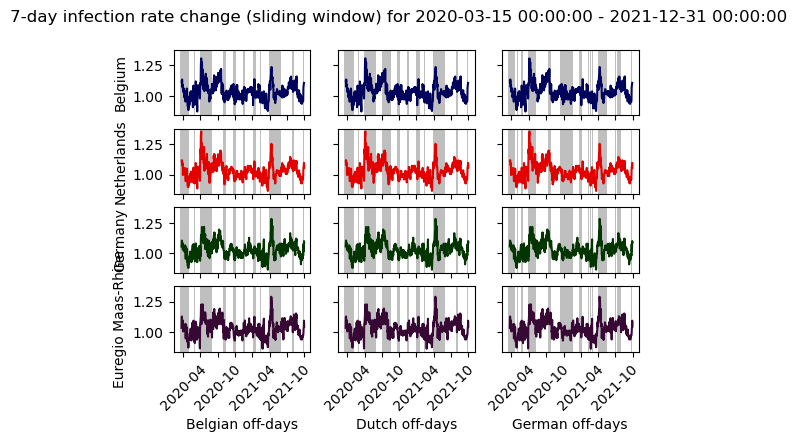

In [13]:
scatterInfectionComparison(emr_df, be_ref_df, nl_ref_df, de_ref_df, settings)

# Forecasting
I ran two diffrent methods of forecasting. One with the skforecast library and one coded iteratively by hand.
Both led me to the conclusion that a near time forecast is pretty accurate, but any forecasts surpassing 1-2-3 days become too unstable to be relevant.

In [14]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput

from joblib import dump, load

def doRunSkForecaster(df, test_range, training_columns, refDf = None):
    fk_df = df.copy()

    data_train = fk_df[:-test_range]
    data_test = fk_df[-test_range:]

    regr = GradientBoostingRegressor(random_state=1, **params)
    forecaster = ForecasterAutoreg( regressor = regr, lags = 100 )
    forecaster.fit(y=data_train.NDRC_Sliding_Window, exog=data_train.loc[:, training_columns])
    predictions = forecaster.predict(steps=test_range, exog=data_test.loc[:, training_columns])

    fig, ax = plt.subplots()
    if refDf is not None:
        mask = (refDf.Date > data_train.index.min()) & (refDf.Date < data_test.index.max())
        addDayOffStreaks(refDf.loc[mask], ax = ax, streakLabel='Off days')
    data_train[-test_range*2:].NDRC_Sliding_Window.plot(ax=ax, label='train')
    data_test.NDRC_Sliding_Window.plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()
    return predictions

The forecast works reasonably well if we use the true value of yesterdays change rate as supporting data for the prediction. The tendencies for each day or spike respectively are learned and can be displayed well.

In [15]:
# _ = doRunSkForecaster(nl_off_dfs[10], 25, settings.training_columns, refDf = nl_ref_df)

The forecast becomes quickly unstable and very inaccurate when based solely on vacation days and recursively calculated change values

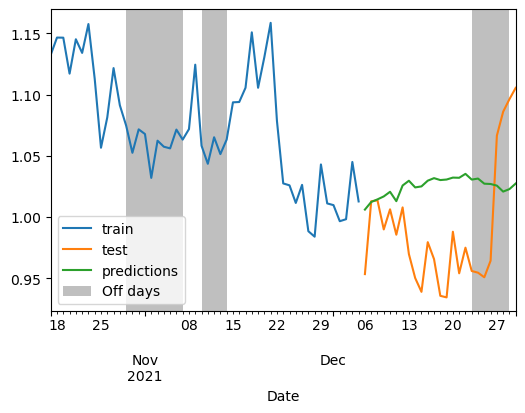

In [16]:
_ = doRunSkForecaster(nl_off_dfs[10], 25, ['OffDay','OffDayFactor'], refDf = nl_ref_df)

# Recursive forecasting
On the handmade forecasting I sketched windows within the data range, to be able to compare multiple scenarios that differ widely.

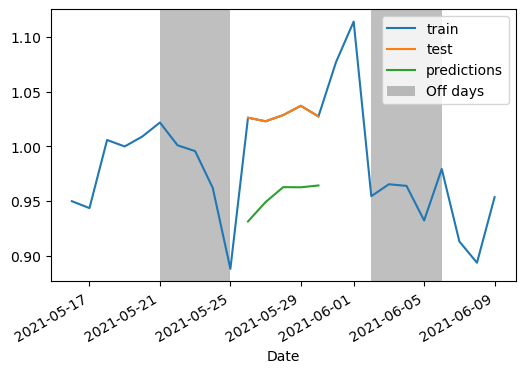

In [19]:
_ = recursiveWindowForecast(de_off_dfs[30],'2021-05-26','2021-05-30', settings, params=params, refDf=de_ref_df, visualWindow=10)
# _ = recursiveWindowForecast(de_off_dfs[30],'2021-10-29','2021-11-05', settings, params=params, refDf=de_ref_df, visualWindow=10)
_ = recursiveWindowForecast(de_off_dfs[30],'2021-12-23','2021-12-31', settings, params=params, refDf=de_ref_df, visualWindow=10)
